In [11]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import collections as c
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 30}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
import random
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
import warnings
warnings.filterwarnings('ignore')

In [12]:
log_reg_model = pickle.load(open('logistic_regression_completion_first_quarter.p', 'rb')) # load the model

In [13]:
log_reg_model.get_params

<bound method BaseEstimator.get_params of LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')>

In [14]:
def scale_subset(df, columns):
    '''
    Use sklearn StandardScalar to scale only numeric columns.

    Parameters:
    ----------
    input {dataframe, list}: dataframe containing mixed feature variable types, list of names of numeric feature columns
    output: {dataframe}: dataframe with numeric features scaled and categorical features unchanged

    '''
    scalar = StandardScaler()
    numeric = df[columns]
    categorical = df.drop(columns, axis = 1)
    scalar.fit(numeric)
    num_scaled = pd.DataFrame(scalar.transform(numeric))
    num_scaled.rename(columns = dict(zip(num_scaled.columns, numeric_cols)), inplace = True)
    return pd.concat([num_scaled, categorical], axis = 1)

def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='blue', 
         lw=3)
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [15]:
X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')
y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'module_presentation_length', 'sum_click_dataplus', 'sum_click_dualpane', 'sum_click_externalquiz', 'sum_click_forumng','sum_click_glossary', 'sum_click_homepage', 'sum_click_htmlactivity', 'sum_click_oucollaborate', 'sum_click_oucontent', 'sum_click_ouelluminate', 'sum_click_ouwiki', 'sum_click_page', 'sum_click_questionnaire', 'sum_click_quiz', 'sum_click_repeatactivity', 'sum_click_resource', 'sum_click_sharedsubpage', 'sum_click_subpage', 'sum_click_url', 'sum_days_vle_accessed', 'max_clicks_one_day', 'first_date_vle_accessed', 'avg_score', 'avg_days_sub_early', 'days_early_first_assessment', 'score_first_assessment']

# fill and scale
X_test.fillna(value = 0, inplace = True)
X_test = scale_subset(X_test, numeric_cols)

high_vif = ['module_presentation_length', 'sum_days_vle_accessed', 'score_first_assessment', 'days_early_first_assessment']
X_test.drop(high_vif, axis = 1, inplace = True)

In [32]:
    predictions = log_reg_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = log_reg_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    class_report = classification_report(y_test, predictions)

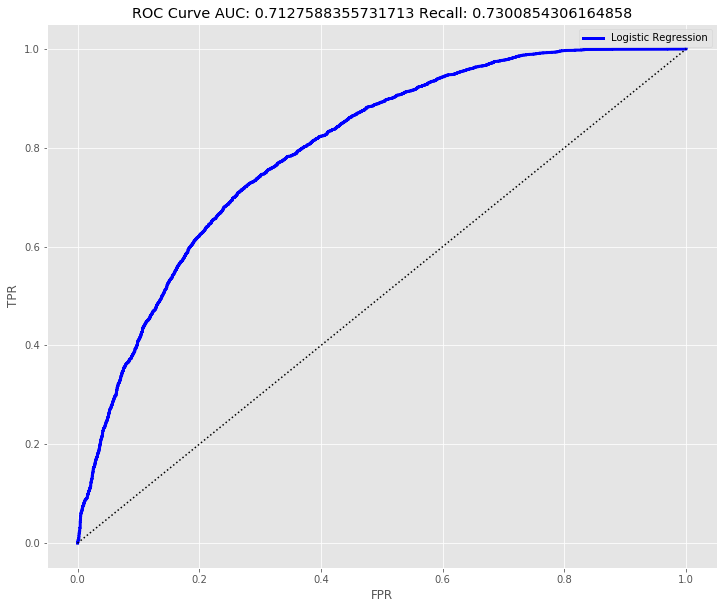

Best Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')

Roc Auc: 0.7127588355731713

Recall Score: 0.7300854306164858

Classification Report:
               precision    recall  f1-score   support

       False       0.74      0.82      0.78      5026
        True       0.71      0.60      0.65      3636

   micro avg       0.73      0.73      0.73      8662
   macro avg       0.73      0.71      0.72      8662
weighted avg       0.73      0.73      0.73      8662


Confusion Matrix:
 [[2199  901]
 [1437 4125]]


In [21]:
    print_roc_curve(y_test, probas, 'Logistic Regression')
    print('Best Model: {}'.format(log_reg_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

In [22]:
## Model Improvement Over Baseline

In [23]:
proportion = y_test.sum() / y_test.shape[0]

In [25]:
# randomly pedict ~1/3 = true
proportion = 0.33567943348158386
baseline_preds = []
for n in range(len(y_test)):
    if random.random() < proportion:
        baseline_preds.append(True)
    else:
        baseline_preds.append(False)

In [27]:
baseline_probas = np.array([proportion] * len(y_test))

In [28]:
    predictions = baseline_preds
    roc_auc = roc_auc_score(y_test, predictions)
    probas = baseline_probas
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

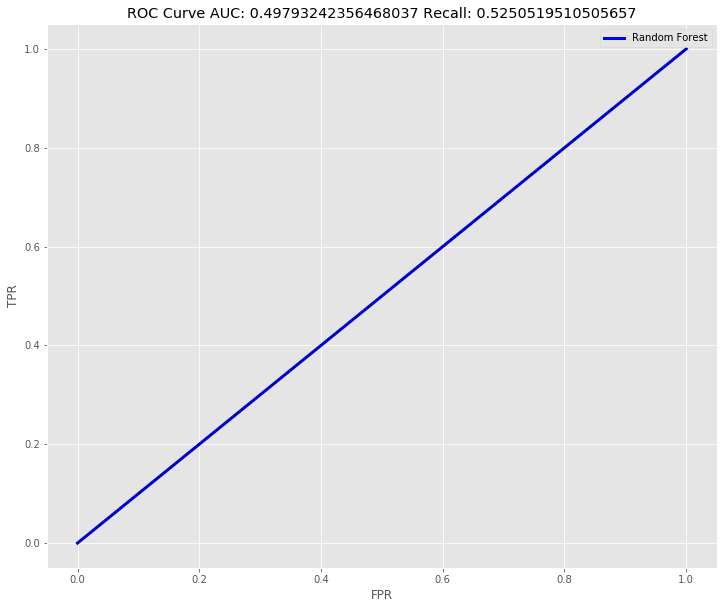

Best Model: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=1e-05, verbose=0, warm_start='False')

Roc Auc: 0.49793242356468037

Recall Score: 0.5250519510505657

Classification Report:
               precision    recall  f1-score   support

       False       0.58      0.67      0.62      5026
        True       0.42      0.33      0.37      3636

   micro avg       0.53      0.53      0.53      8662
   macro avg       0.50      0.50      0.49      8662
weighted avg       0.51      0.53      0.51      8662


Confusion Matrix:
 [[1196 1674]
 [2440 3352]]


In [29]:
    print_roc_curve(y_test, probas, 'Random Forest')
    print('Best Model: {}'.format(log_reg_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

## Feature Importance

In [30]:
    # Feature Importances
    abs_coef = list(np.abs(log_reg_model.coef_.ravel()))
    features = list(X_test.columns)
    coef_dict = c.OrderedDict((zip(abs_coef, features)))
    print('The top twenty features affecting completion are:\n')
    sorted(coef_dict.items(), reverse=True)[:20]

The top twenty features affecting completion are:



[(1.5186868403730531, 'code_module_GGG'),
 (1.3153679258422877, 'code_module_CCC'),
 (1.0614995029980325, 'code_module_FFF'),
 (1.0376517983459177, 'avg_score'),
 (1.0194156616080439, 'code_module_EEE'),
 (0.9402968731588808, 'code_module_DDD'),
 (0.7868355951578551, 'imd_band_nan'),
 (0.6954686252208483, 'highest_education_No Formal quals'),
 (0.5596372243806385, 'highest_education_Lower Than A Level'),
 (0.5101631769085959, 'imd_band_90-100%'),
 (0.41779651239760274, 'imd_band_80-90%'),
 (0.41095879929977297, 'code_presentation_2014B'),
 (0.40028825857371914, 'sum_click_homepage'),
 (0.35074833182290677, 'imd_band_60-70%'),
 (0.34653994129336174, 'imd_band_70-80%'),
 (0.3278745132465828, 'region_Scotland'),
 (0.3177022920120091, 'sum_click_oucontent'),
 (0.31595153120988834, 'code_presentation_2014J'),
 (0.30137460102154306, 'disability_Y'),
 (0.29617829865905554, 'region_Wales')]

## Choosing a Threshold

In [33]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:100]

,fprs,tprs,Thresholds
800,0.132838,0.487067,0.748954
900,0.149065,0.526263,0.729099
1000,0.167767,0.565659,0.708807
1100,0.185919,0.600875,0.686649
1200,0.207371,0.631715,0.667594
1300,0.230198,0.663351,0.644798
1400,0.251100,0.690410,0.624014
1500,0.271727,0.716474,0.604335
1600,0.297580,0.740549,0.583589
1700,0.322607,0.760844,0.562941


In [34]:
    t = 0.5 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

       False       0.74      0.82      0.78      5026
        True       0.71      0.60      0.65      3636

   micro avg       0.73      0.73      0.73      8662
   macro avg       0.73      0.71      0.72      8662
weighted avg       0.73      0.73      0.73      8662


Confusion Matrix at Threshold 0.5:
 [[2199  901]
 [1437 4125]]


In [37]:
    t = 0.4 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.4:
               precision    recall  f1-score   support

       False       0.78      0.72      0.75      5026
        True       0.65      0.72      0.69      3636

   micro avg       0.72      0.72      0.72      8662
   macro avg       0.72      0.72      0.72      8662
weighted avg       0.73      0.72      0.72      8662


Confusion Matrix at Threshold 0.4:
 [[2633 1402]
 [1003 3624]]


In [38]:
    t = 0.3 # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.3:
               precision    recall  f1-score   support

       False       0.82      0.58      0.68      5026
        True       0.59      0.82      0.69      3636

   micro avg       0.68      0.68      0.68      8662
   macro avg       0.70      0.70      0.68      8662
weighted avg       0.72      0.68      0.68      8662


Confusion Matrix at Threshold 0.3:
 [[2997 2114]
 [ 639 2912]]


In [39]:
    t = proportion # threshold for predicting positive    
    predictions = (log_reg_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.33567943348158386:
               precision    recall  f1-score   support

       False       0.81      0.64      0.71      5026
        True       0.61      0.79      0.69      3636

   micro avg       0.70      0.70      0.70      8662
   macro avg       0.71      0.71      0.70      8662
weighted avg       0.72      0.70      0.70      8662


Confusion Matrix at Threshold 0.33567943348158386:
 [[2872 1829]
 [ 764 3197]]
